In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # Explained variance
    evr = pca.explained_variance_ratio_  # 每个主成分的解释方差比例
    axs[0].bar(grid, evr)  # 生成条形图，展示每个主成分的解释方差比例
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    
    # Cumulative Variance
    cv = np.cumsum(evr)  # 计算累计解释方差
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")  # 生成折线图，展示累计解释方差
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs



def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings
df = pd.read_csv("../input/ames.csv")

In [13]:
features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

print("Correlation with SalePrice:\n")
print(df[features].corrwith(df.SalePrice))

Correlation with SalePrice:

GarageArea      0.640138
YearRemodAdd    0.532974
TotalBsmtSF     0.632529
GrLivArea       0.706780
dtype: float64


In [14]:
X = df.copy()
y = X.pop("SalePrice")
X = X.loc[:, features]

# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X)
print(loadings)
X_pca


                   PC1       PC2       PC3       PC4
GarageArea    0.541229 -0.102375 -0.038470  0.833733
YearRemodAdd  0.427077  0.886612 -0.049062 -0.170639
TotalBsmtSF   0.510076 -0.360778 -0.666836 -0.406192
GrLivArea     0.514294 -0.270700  0.742592 -0.332837


,PC1,PC2,PC3,PC4
0,-0.165346,-1.164936,0.233330,0.283527
1,-0.639050,-0.649561,-0.622155,1.740770
2,-0.794227,-1.175790,-0.580254,-0.551055
3,1.636658,-1.907874,-0.675063,-1.052854
4,0.293648,0.610856,0.342374,-0.047752
...,...,...,...,...
2925,-0.276496,0.239255,-0.676658,0.820547
2926,-0.822084,0.414039,-0.593885,0.620322
2927,-1.730457,0.951137,-0.501221,-1.417521
2928,-0.049130,-0.584898,-0.641779,-0.374198


In [15]:
X

,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
0,528.0,1960,1080.0,1656.0
1,730.0,1961,882.0,896.0
2,312.0,1958,1329.0,1329.0
3,522.0,1968,2110.0,2110.0
4,482.0,1998,928.0,1629.0
...,...,...,...,...
2925,588.0,1984,1003.0,1003.0
2926,484.0,1983,864.0,902.0
2927,0.0,1992,912.0,970.0
2928,418.0,1975,1389.0,1389.0


In [16]:
pca.components_

array([[ 0.54122942,  0.42707725,  0.5100756 ,  0.51429428],
       [-0.10237467,  0.88661165, -0.36077798, -0.27069995],
       [-0.03846963, -0.04906151, -0.66683607,  0.74259189],
       [ 0.83373271, -0.17063932, -0.4061918 , -0.33283662]])

In [17]:
X = df.copy()
y = X.pop("SalePrice")

X = X.join(X_pca)
score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

Your score: 0.13957 RMSLE


In [20]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,PC1,PC2,PC3,PC4
0,0,0,141.0,31770.0,0,0,0,0,0,0,...,-1,0.0,5,2010,0,0,-0.165346,-1.164936,0.233330,0.283527
1,0,1,80.0,11622.0,0,0,1,0,0,1,...,-1,0.0,6,2010,0,0,-0.639050,-0.649561,-0.622155,1.740770
2,0,0,81.0,14267.0,0,0,0,0,0,0,...,0,12500.0,6,2010,0,0,-0.794227,-1.175790,-0.580254,-0.551055
3,0,0,93.0,11160.0,0,0,1,0,0,0,...,-1,0.0,4,2010,0,0,1.636658,-1.907874,-0.675063,-1.052854
4,1,0,74.0,13830.0,0,0,0,0,0,1,...,-1,0.0,3,2010,0,0,0.293648,0.610856,0.342374,-0.047752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,6,0,37.0,7937.0,0,0,0,0,0,2,...,-1,0.0,3,2006,0,0,-0.276496,0.239255,-0.676658,0.820547
2926,0,0,0.0,8885.0,0,0,0,3,0,1,...,-1,0.0,6,2006,0,0,-0.822084,0.414039,-0.593885,0.620322
2927,4,0,62.0,10441.0,0,0,1,0,0,1,...,1,700.0,7,2006,0,0,-1.730457,0.951137,-0.501221,-1.417521
2928,0,0,77.0,10010.0,0,0,1,0,0,1,...,-1,0.0,4,2006,0,0,-0.049130,-0.584898,-0.641779,-0.374198


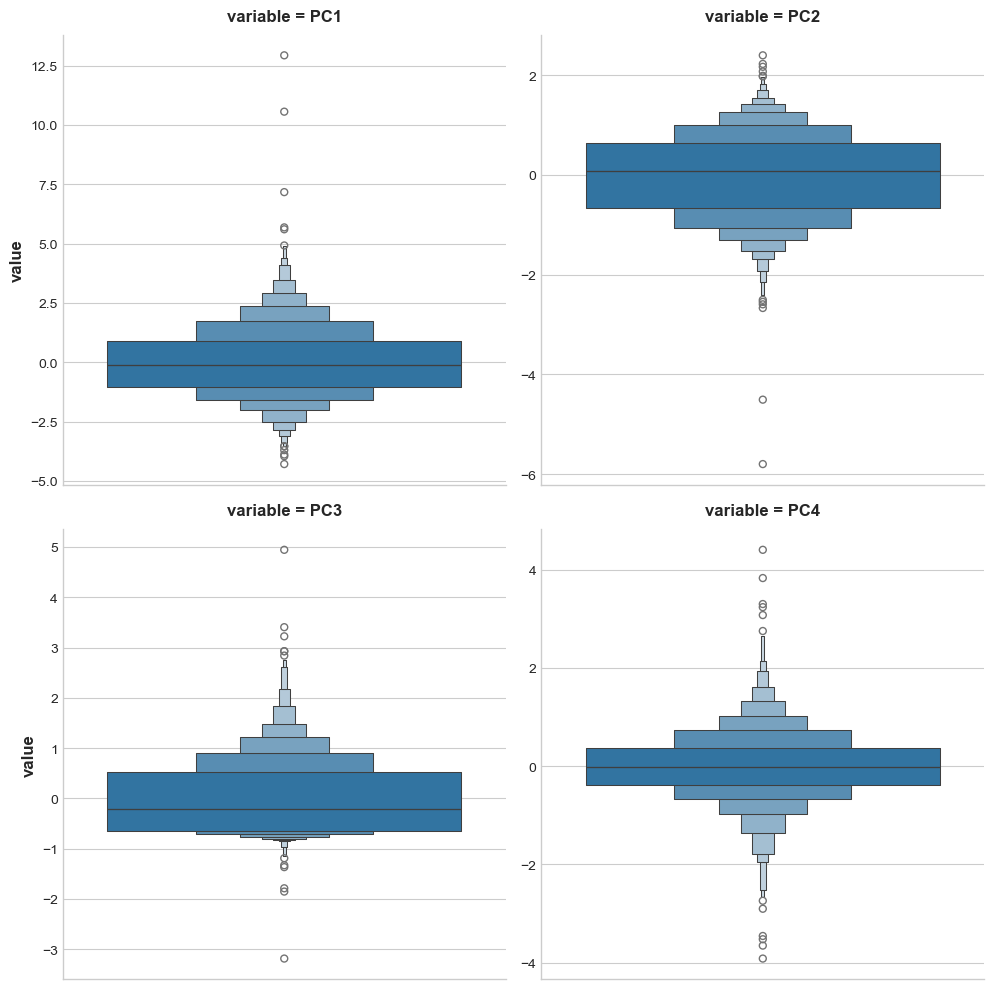

In [18]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [19]:
# You can change PC1 to PC2, PC3, or PC4
component = "PC1"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
2181,184750,Edwards,Partial,884.0,2008,3138.0,4676.0
1760,745000,Northridge,Abnorml,813.0,1996,2396.0,4476.0
1767,755000,Northridge,Normal,832.0,1995,2444.0,4316.0
...,...,...,...,...,...,...,...
662,59000,Old_Town,Normal,0.0,1950,416.0,599.0
2679,80500,Brookside,Normal,0.0,1950,0.0,912.0
2879,51689,Iowa_DOT_and_Rail_Road,Abnorml,0.0,1950,0.0,729.0
780,63900,Sawyer,Normal,0.0,1950,0.0,660.0
